### **<h1 align="center">Prediction Eligibilité à un Crédit</h1>**

## Import CSV to dataframe

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Importation des données du csv dans un dataframe
loan_data_df = pd.read_csv("loan_data_raw.csv")

## Initial Data Exploration

### Dataframe Statistics

#### Shape

In [2]:
loan_data_df.shape

(981, 13)

#### Column Types

In [3]:
loan_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            981 non-null    object 
 1   Gender             957 non-null    object 
 2   Married            978 non-null    object 
 3   Dependents         956 non-null    object 
 4   Education          981 non-null    object 
 5   Self_Employed      926 non-null    object 
 6   ApplicantIncome    981 non-null    int64  
 7   CoapplicantIncome  981 non-null    float64
 8   LoanAmount         954 non-null    float64
 9   Loan_Amount_Term   961 non-null    float64
 10  Credit_History     902 non-null    float64
 11  Property_Area      981 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 99.8+ KB


#### Missing data

In [4]:
loan_data_df.isna().sum()

Loan_ID                0
Gender                24
Married                3
Dependents            25
Education              0
Self_Employed         55
ApplicantIncome        0
CoapplicantIncome      0
LoanAmount            27
Loan_Amount_Term      20
Credit_History        79
Property_Area          0
Loan_Status          367
dtype: int64

### Distribution Graphs

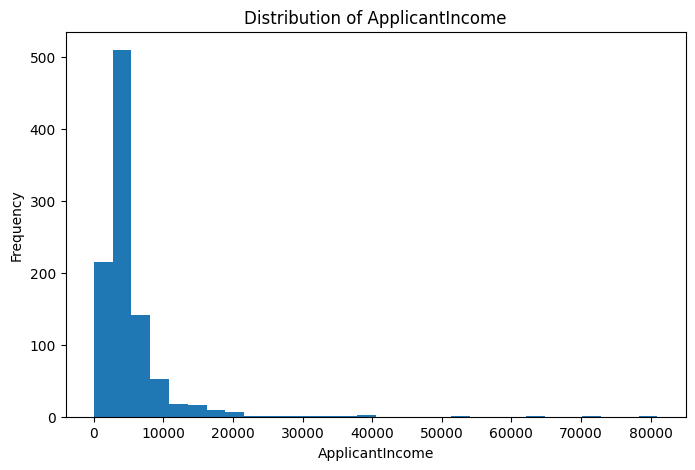

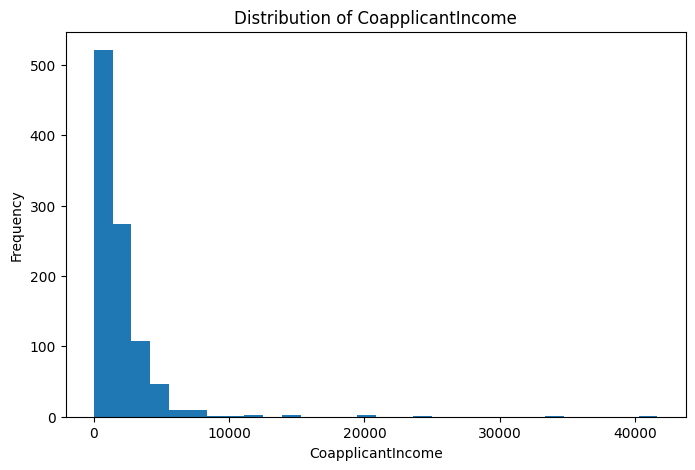

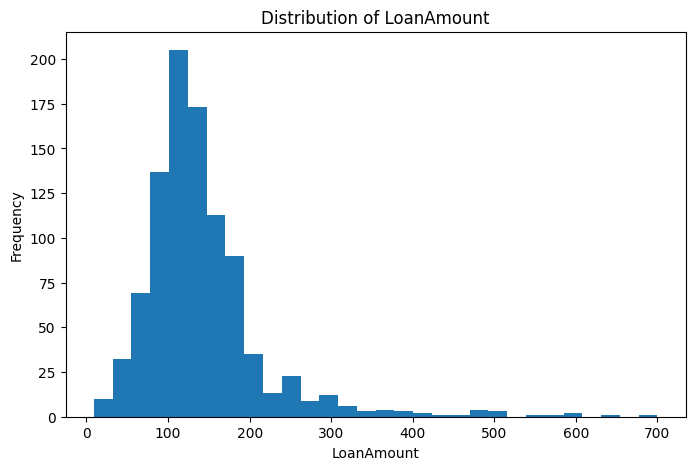

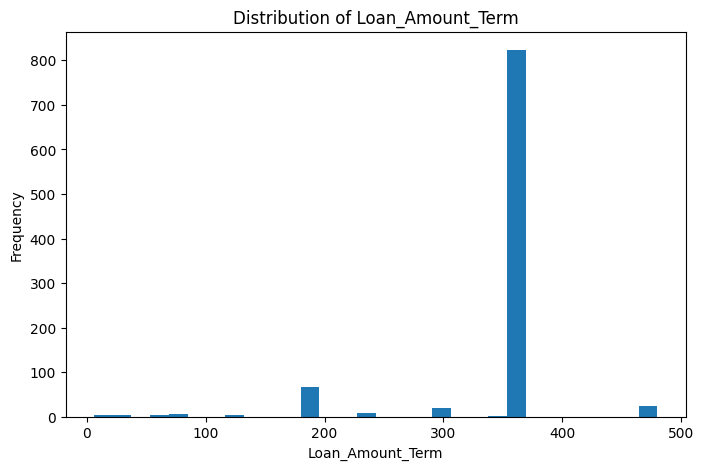

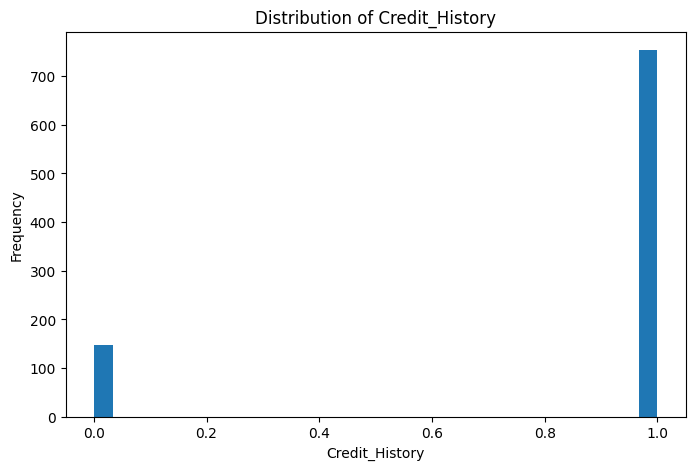

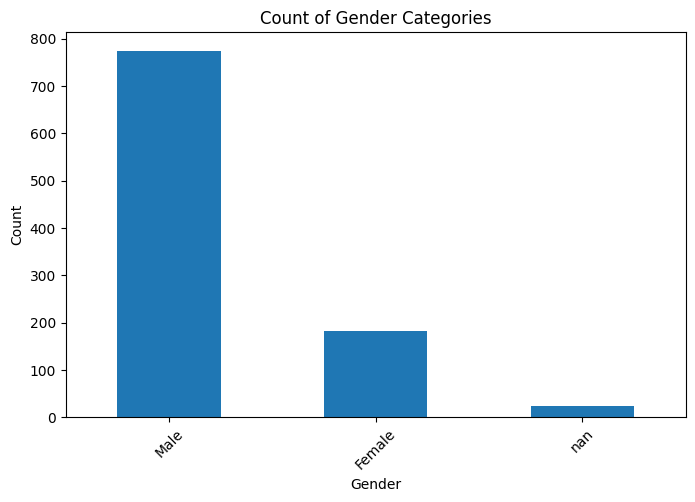

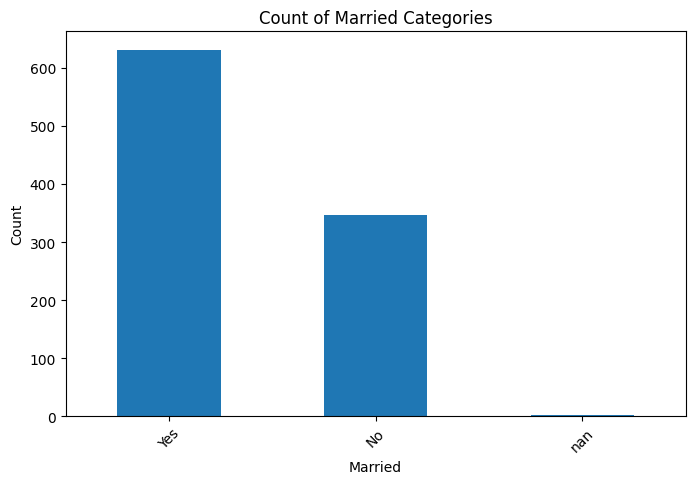

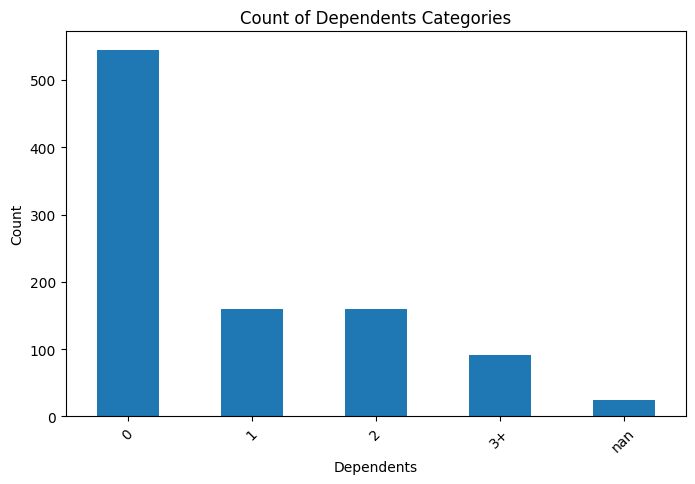

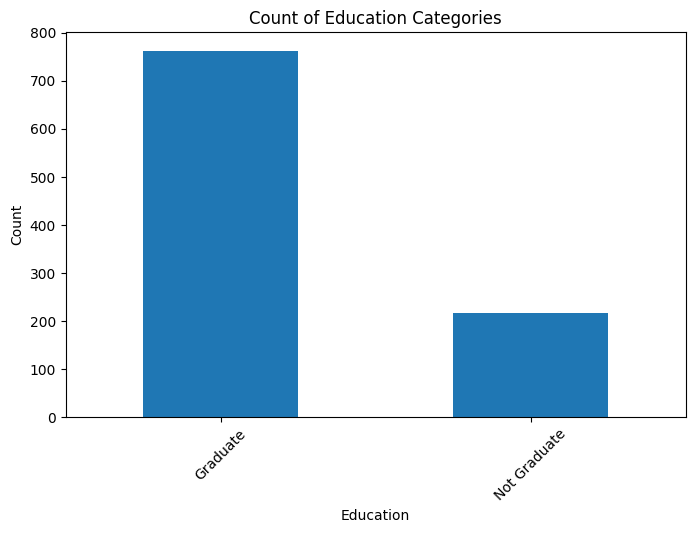

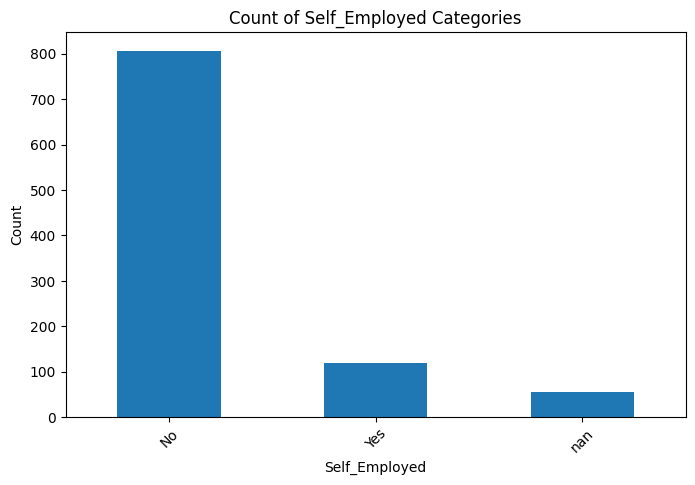

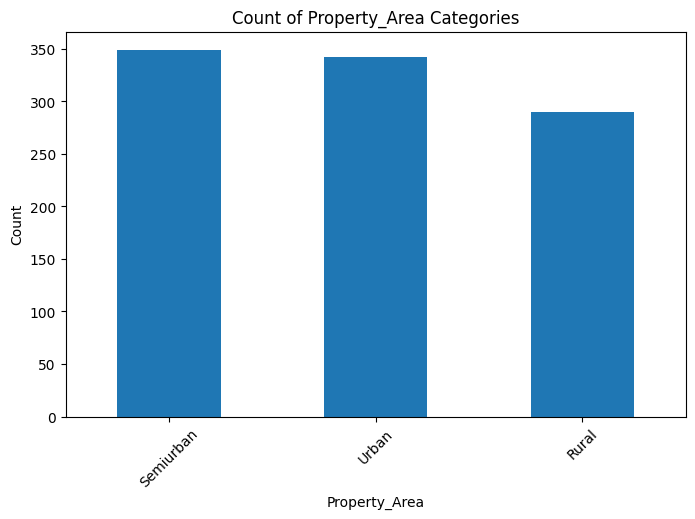

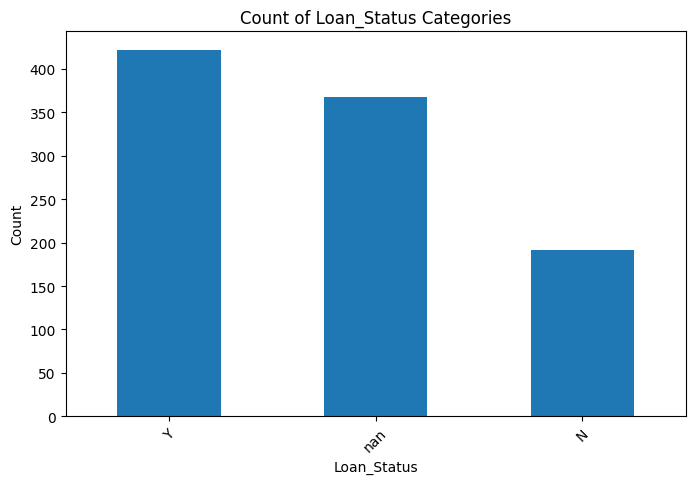

In [5]:
# Afficher les distributions des variables numériques
def display_numerical_distribution(df, numerical_columns):
    """
    Display the distribution of numerical columns in the dataframe.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    numerical_columns (list): List of numerical columns to plot.
    """
    for column in numerical_columns:
        plt.figure(figsize=(8, 5))
        df[column].dropna().hist(bins=30)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(False)
        plt.show()

# Afficher les distributions des variables catégorielles
def display_categorical_distribution(df, categorical_columns):
    """
    Display the distribution of categorical columns in the dataframe.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    categorical_columns (list): List of categorical columns to plot.
    """
    for column in categorical_columns:
        plt.figure(figsize=(8, 5))
        df[column].value_counts(dropna=False).plot(kind='bar')
        plt.title(f'Count of {column} Categories')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.grid(False)
        plt.show()

# Visualisation des colonnes numériques
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
display_numerical_distribution(loan_data_df, numerical_columns)

# Visualisation des variables catégoriques, y compris la cible
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
display_categorical_distribution(loan_data_df, categorical_columns)

### Missing Value Heatmap

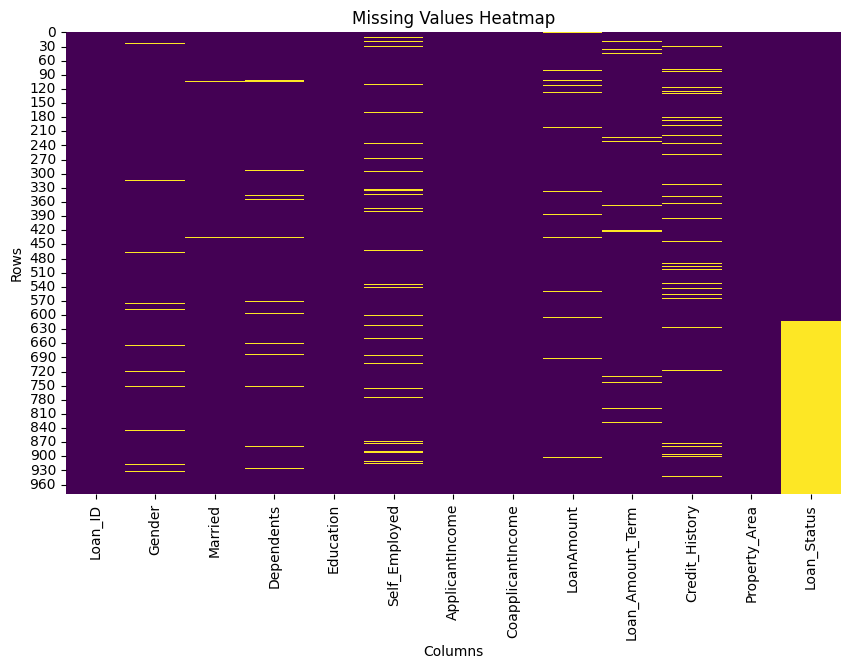

In [6]:
def plot_missing_values(dataframe):
    plt.figure(figsize=(10, 6))
    sns.heatmap(dataframe.isnull(), cbar=False, cmap='viridis')
    plt.title("Missing Values Heatmap")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()

plot_missing_values(loan_data_df)

### Correlation Matrix

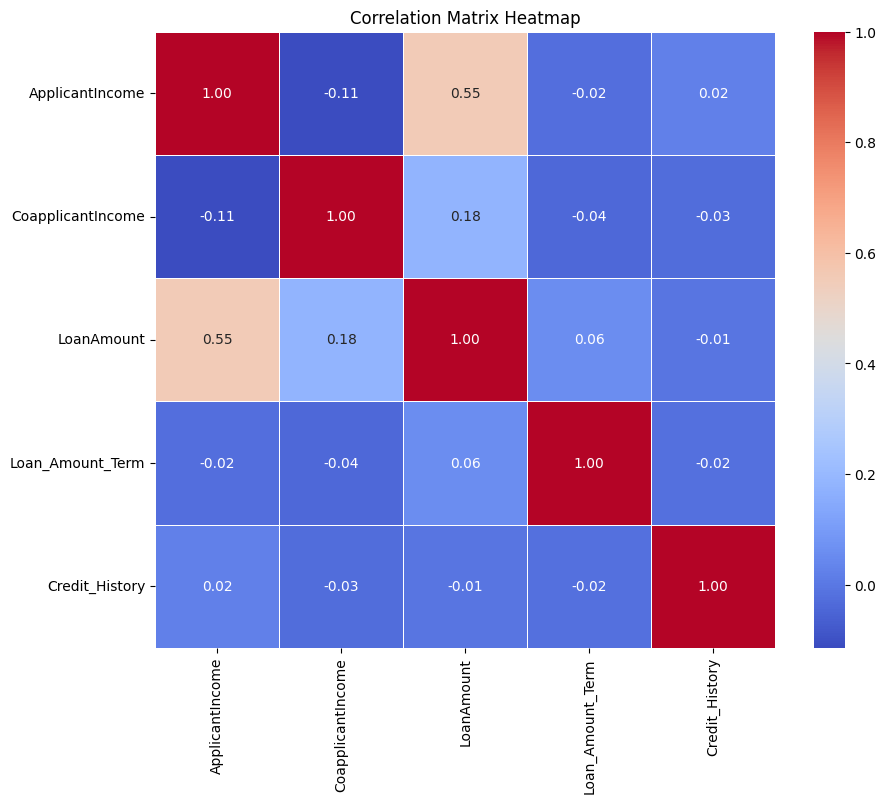

In [7]:
def display_correlation_matrix(dataframe):
    """
    Displays a heatmap of the correlation matrix for all numeric columns in the dataframe.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe containing the data.

    Returns:
    - None: Displays the heatmap directly.
    """
    # Select only numeric columns
    numeric_dataframe = dataframe.select_dtypes(include=['number'])

    if numeric_dataframe.empty:
        print("No numeric columns found in the dataframe.")
        return

    # Calculate and display the correlation matrix
    plt.figure(figsize=(10, 8))
    correlation_matrix = numeric_dataframe.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix Heatmap")
    plt.show()


# Display correlation matrix heatmap
display_correlation_matrix(loan_data_df)

### Correlation to Target Variable

Target column 'Loan_Status' encoded as: {'Y': 1, 'N': 0}


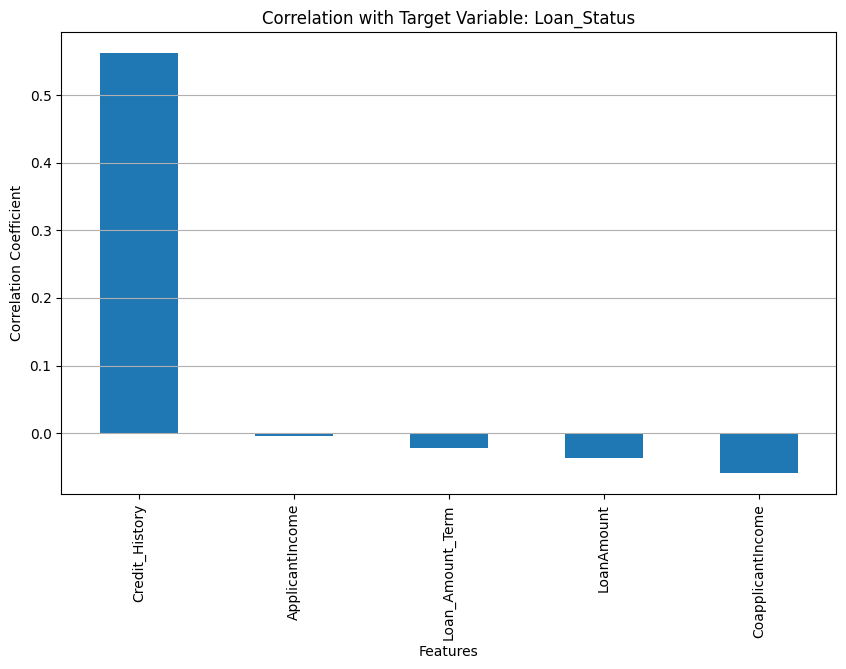

In [8]:
def display_correlations_with_target(dataframe, target_column):
    """
    Displays a bar plot of correlations between all numeric columns and the target variable.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - target_column (str): The target column to calculate correlations with.

    Returns:
    - None: Displays the bar plot directly.
    """
    if target_column not in dataframe.columns:
        print(f"Target column '{target_column}' not found in the dataframe.")
        return

    # Encode the target column if it is non-numeric
    if not pd.api.types.is_numeric_dtype(dataframe[target_column]):
        dataframe = dataframe.copy()  # Avoid modifying the original dataframe
        target_mapping = {'Y': 1, 'N': 0}  # Inverted encoding
        dataframe[target_column] = dataframe[target_column].map(target_mapping)
        print(f"Target column '{target_column}' encoded as: {target_mapping}")

    # Select numeric columns
    numeric_dataframe = dataframe.select_dtypes(include=['number'])

    if target_column not in numeric_dataframe.columns:
        print(f"Target column '{target_column}' could not be converted to numeric.")
        return

    # Calculate correlations with the target column
    correlations = numeric_dataframe.corr()[target_column].drop(target_column)

    # Plot the correlations
    plt.figure(figsize=(10, 6))
    correlations.sort_values(ascending=False).plot(kind='bar')
    plt.title(f"Correlation with Target Variable: {target_column}")
    plt.ylabel("Correlation Coefficient")
    plt.xlabel("Features")
    plt.grid(axis='y')
    plt.show()


# Display correlations with target variable 'Loan_Status'
display_correlations_with_target(loan_data_df, target_column="Loan_Status")

### Outliers Graphs

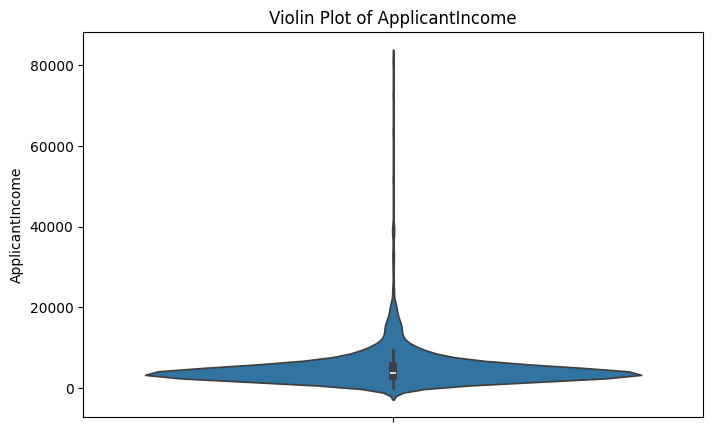

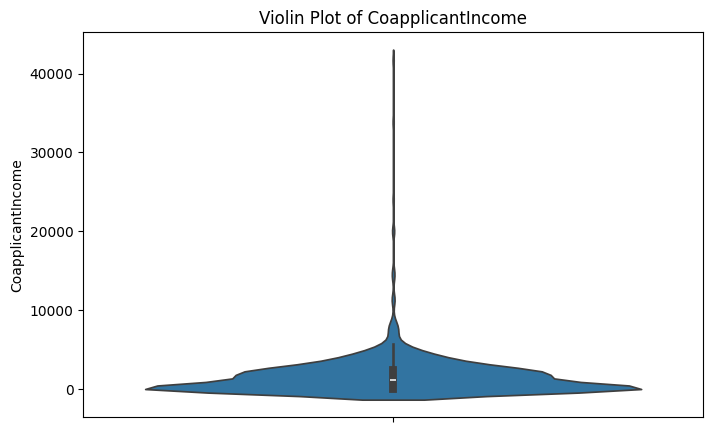

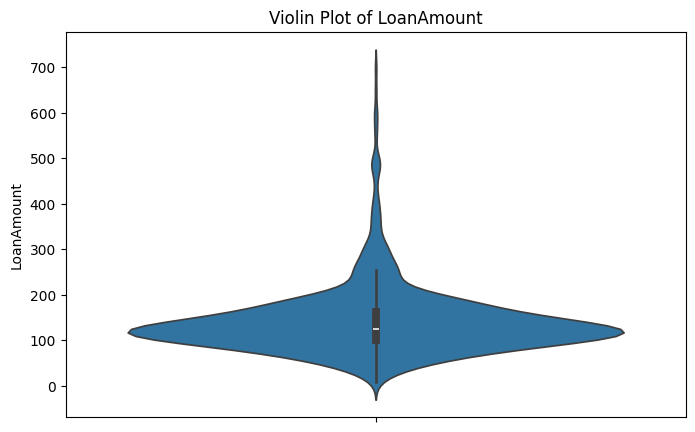

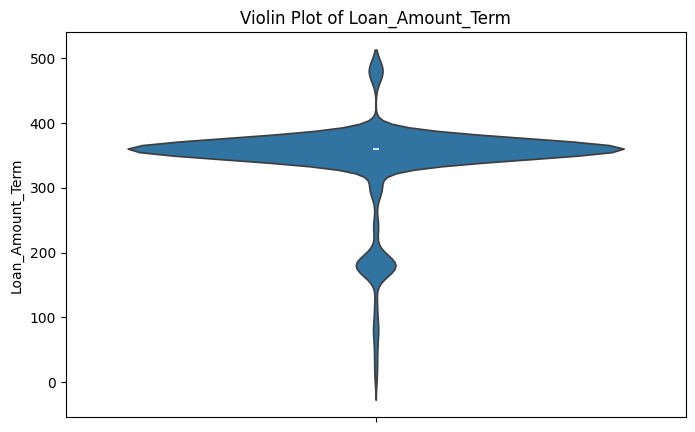

In [9]:
def display_outliers(dataframe, selected_columns):
    """
    Displays boxplots for the selected columns to visualize potential outliers.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - selected_columns (list): List of columns to display outliers.

    Returns:
    - None: Displays the graphs directly.
    """
    for column in selected_columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            plt.figure(figsize=(8, 5))
            sns.boxplot(y=dataframe[column])
            plt.title(f'Boxplot of {column}')
            plt.ylabel(column)
            plt.show()
        else:
            print(f"Column '{column}' is not numeric and was skipped.")

def display_outliers_violin(dataframe, selected_columns):
    """
    Displays violin plots for the selected columns to visualize potential outliers.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - selected_columns (list): List of columns to display outliers.

    Returns:
    - None: Displays the graphs directly.
    """
    for column in selected_columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            plt.figure(figsize=(8, 5))
            sns.violinplot(y=dataframe[column])
            plt.title(f'Violin Plot of {column}')
            plt.ylabel(column)
            plt.show()
        else:
            print(f"Column '{column}' is not numeric and was skipped.")

# Visualize outliers
display_outliers_violin(loan_data_df, selected_columns=["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"])

## Data preprocessing

### Duplicates Handling

In [10]:
def find_duplicates(dataframe, selected_columns):
    """
    Finds duplicates in the given dataframe based on selected columns.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe to search for duplicates.
    - selected_columns (list): The columns to check for duplicates.

    Returns:
    - int: Number of duplicate rows found.
    """
    duplicates = dataframe.duplicated(subset=selected_columns)
    return duplicates.sum()

def drop_duplicates(dataframe, keep):
    """
    Drops duplicate rows in the dataframe.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe from which to remove duplicates.
    - keep (str): Which duplicates to keep ('first', 'last', or False).

    Returns:
    - pd.DataFrame: A dataframe with duplicates removed.
    """
    return dataframe.drop_duplicates(keep=keep)

# Find duplicates
num_duplicates = find_duplicates(loan_data_df, selected_columns=["Loan_ID"])
print(f"Number of duplicates: {num_duplicates}")

# Drop duplicates if any
if num_duplicates > 0:
    loan_data_df_cleaned = drop_duplicates(loan_data_df, keep='first')  # Keep the first occurrence
    print("Duplicates removed. Cleaned DataFrame:")
    print(loan_data_df_cleaned)
else:
    loan_data_df_cleaned = loan_data_df

loan_data_df_cleaned.describe()

Number of duplicates: 0


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,981.000000,981.000000,954.000000,961.000000,902.000000
mean,5179.795107,1601.916330,142.511530,342.201873,0.835920
std,5695.104533,2718.772806,77.421743,65.100602,0.370553
min,0.000000,0.000000,9.000000,6.000000,0.000000
25%,2875.000000,0.000000,100.000000,360.000000,1.000000
50%,3800.000000,1110.000000,126.000000,360.000000,1.000000
75%,5516.000000,2365.000000,162.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


### Handling Missing Values

#### Functions

In [11]:
def fill_missing_with_knn(dataframe, selected_columns, n_neighbors=5):
    """
    Fills missing values in selected columns using K-Nearest Neighbors (KNN).

    Parameters:
    - dataframe (pd.DataFrame): The dataframe to process.
    - selected_columns (list): Columns where missing values will be imputed.
    - n_neighbors (int): Number of neighbors to use for KNN imputation.

    Returns:
    - pd.DataFrame: A dataframe with missing values imputed using KNN.
    """
    # Ensure selected columns are numeric
    numeric_columns = []
    for col in selected_columns:
        if not pd.api.types.is_numeric_dtype(dataframe[col]):
            try:
                dataframe[col] = pd.to_numeric(dataframe[col], errors="coerce")
            except Exception as e:
                print(f"Error converting column {col} to numeric: {e}")
        numeric_columns.append(col)

    # Apply KNN imputation
    imputer = KNNImputer(n_neighbors=n_neighbors)
    dataframe[numeric_columns] = imputer.fit_transform(dataframe[numeric_columns])

    return dataframe


def split_dataframe_on_missing_target(dataframe, target_column):
    """
    Splits a dataframe into two based on missing values in the target column.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe to split.
    - target_column (str): The column to check for missing values.

    Returns:
    - pd.DataFrame: A dataframe containing rows where the target_column has no missing values.
    - pd.DataFrame: A dataframe containing rows where the target_column has missing values.
    """
    # Create a mask for rows with missing values in the target column
    missing_target_df = dataframe[dataframe[target_column].isnull()]
    
    # Create a dataframe without missing values in the target column
    cleaned_df = dataframe.dropna(subset=[target_column])
    
    return cleaned_df, missing_target_df


def fill_missing_with_value(dataframe, selected_columns, value):
    """
    Fills missing values in selected columns with the given value.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe to process.
    - selected_columns (list): Columns where missing values will be replaced.
    - value: The value to replace missing data with.

    Returns:
    - pd.DataFrame: DataFrame with missing values replaced.
    """
    dataframe[selected_columns] = dataframe[selected_columns].fillna(value)
    return dataframe

def fill_missing_with_mean(dataframe, selected_columns):
    """
    Fills missing values in selected columns with the mean of each column.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe to process.
    - selected_columns (list): Columns where missing values will be replaced.

    Returns:
    - pd.DataFrame: DataFrame with missing values replaced by column mean.
    """
    for column in selected_columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            dataframe[column] = dataframe[column].fillna(dataframe[column].mean())
    return dataframe

def fill_missing_with_median(dataframe, selected_columns):
    """
    Fills missing values in selected columns with the median of each column.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe to process.
    - selected_columns (list): Columns where missing values will be replaced.

    Returns:
    - pd.DataFrame: DataFrame with missing values replaced by column median.
    """
    for column in selected_columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            dataframe[column] = dataframe[column].fillna(dataframe[column].median())
    return dataframe

def drop_rows_with_missing(dataframe, selected_columns):
    """
    Drops rows with missing values in the selected columns.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe to process.
    - selected_columns (list): Columns to check for missing values.

    Returns:
    - pd.DataFrame: DataFrame with rows containing missing values removed.
    """
    return dataframe.dropna(subset=selected_columns)

# Do not use, not useful in this case
def drop_columns_with_missing(dataframe, selected_columns=None):
    """
    Drops columns with missing values. If selected_columns is None, checks all columns.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe to process.
    - selected_columns (list or None): Columns to check for missing values. If None, checks all columns.

    Returns:
    - pd.DataFrame: DataFrame with columns containing missing values removed.
    """
    if selected_columns is None:
        return dataframe.dropna(axis=1)
    else:
        return dataframe.drop(columns=[col for col in selected_columns if dataframe[col].isnull().any()])

#### Applying functions to this dataframe

##### Split the dataframe based on missing values in 'Loan_Status'

In [12]:
loan_data_df_cleaned, missing_target_df = split_dataframe_on_missing_target(loan_data_df_cleaned, target_column="Loan_Status")

In [13]:
# Checks resulting dataframe
loan_data_df_cleaned.shape

(614, 13)

In [14]:
loan_data_df_cleaned.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

##### Low impact handling (few values)

In [15]:
#loan_data_df_cleaned = fill_missing_with_value(loan_data_df_cleaned, selected_columns=["Gender"], value="Unknown")

loan_data_df_cleaned = drop_rows_with_missing(loan_data_df_cleaned, selected_columns=["Gender", "Married", "Dependents", "LoanAmount", "Loan_Amount_Term"])

In [16]:
loan_data_df_cleaned.shape

(553, 13)

In [17]:
loan_data_df_cleaned.isna().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed        30
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History       48
Property_Area         0
Loan_Status           0
dtype: int64

In [18]:
loan_data_df_cleaned.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,553.000000,553.000000,553.000000,553.000000,505.000000
mean,5350.018083,1659.119204,146.001808,341.663653,0.859406
std,5965.429068,3043.448229,84.052035,65.555451,0.347947
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2889.000000,0.000000,100.000000,360.000000,1.000000
50%,3812.000000,1213.000000,128.000000,360.000000,1.000000
75%,5815.000000,2306.000000,170.000000,360.000000,1.000000
max,81000.000000,41667.000000,650.000000,480.000000,1.000000


##### High impact handling (lots of values)

In [19]:
#loan_data_df_cleaned = fill_missing_with_mean(loan_data_df_cleaned, selected_columns=["LoanAmount", "ApplicantIncome"])

#loan_data_df_cleaned = fill_missing_with_median(loan_data_df_cleaned, selected_columns=["LoanAmount"])

loan_data_df_cleaned = drop_rows_with_missing(loan_data_df_cleaned, selected_columns=["Self_Employed", "Credit_History"])

### Outliers

#### Functions

In [20]:
def remove_outliers_iqr(dataframe, selected_columns):
    """
    Removes rows containing outliers based on the IQR method for the selected columns.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe to process.
    - selected_columns (list): Columns where outliers will be removed.

    Returns:
    - pd.DataFrame: A dataframe with outliers removed.
    """
    df_cleaned = dataframe.copy()
    for column in selected_columns:
        if pd.api.types.is_numeric_dtype(df_cleaned[column]):
            q1 = df_cleaned[column].quantile(0.25)
            q3 = df_cleaned[column].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    return df_cleaned


def cap_outliers(dataframe, selected_columns, method="iqr"):
    """
    Caps outliers to the lower and upper bounds based on the chosen method.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe to process.
    - selected_columns (list): Columns where outliers will be capped.
    - method (str): Method to calculate bounds ("iqr" or "zscore").

    Returns:
    - pd.DataFrame: A dataframe with capped outliers.
    """
    df_capped = dataframe.copy()
    for column in selected_columns:
        if pd.api.types.is_numeric_dtype(df_capped[column]):
            if method == "iqr":
                q1 = df_capped[column].quantile(0.25)
                q3 = df_capped[column].quantile(0.75)
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
            elif method == "zscore":
                mean = df_capped[column].mean()
                std = df_capped[column].std()
                lower_bound = mean - 3 * std
                upper_bound = mean + 3 * std
            else:
                raise ValueError("Invalid method. Choose 'iqr' or 'zscore'.")
            
            df_capped[column] = np.clip(df_capped[column], lower_bound, upper_bound)
    return df_capped


def replace_outliers_with_median(dataframe, selected_columns):
    """
    Replaces outliers in the selected columns with the column's median value.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe to process.
    - selected_columns (list): Columns where outliers will be replaced.

    Returns:
    - pd.DataFrame: A dataframe with outliers replaced by median values.
    """
    df_replaced = dataframe.copy()
    for column in selected_columns:
        if pd.api.types.is_numeric_dtype(df_replaced[column]):
            q1 = df_replaced[column].quantile(0.25)
            q3 = df_replaced[column].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            median = df_replaced[column].median()
            df_replaced[column] = df_replaced[column].apply(
                lambda x: median if x < lower_bound or x > upper_bound else x
            )
    return df_replaced

#### Outliers handling

Commented everything since scores are much better if I don't remove outliers !

In [21]:
# Remove outliers using IQR
#loan_data_df_cleaned = remove_outliers_iqr(loan_data_df_cleaned, selected_columns=["ApplicantIncome", "CoapplicantIncome", "LoanAmount"])

#loan_data_df_cleaned = remove_outliers_iqr(loan_data_df_cleaned, selected_columns=["ApplicantIncome", "LoanAmount"])

In [22]:
loan_data_df_cleaned.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,480.000000,480.000000,480.000000,480.000000,480.000000
mean,5364.231250,1581.093583,144.735417,342.050000,0.854167
std,5668.251251,2617.692267,80.508164,65.212401,0.353307
min,150.000000,0.000000,9.000000,36.000000,0.000000
25%,2898.750000,0.000000,100.000000,360.000000,1.000000
50%,3859.000000,1084.500000,128.000000,360.000000,1.000000
75%,5852.500000,2253.250000,170.000000,360.000000,1.000000
max,81000.000000,33837.000000,600.000000,480.000000,1.000000


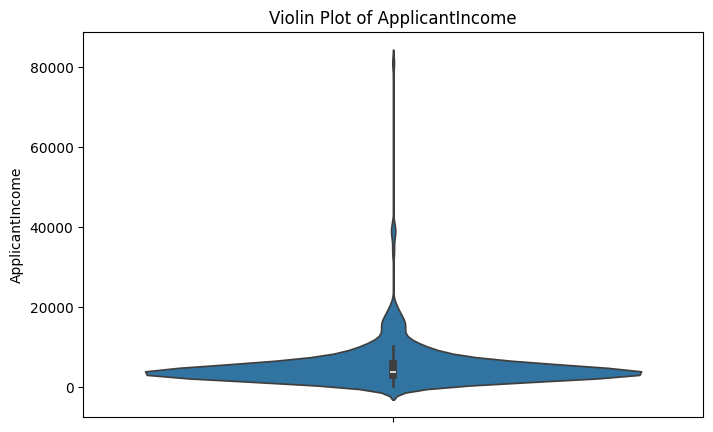

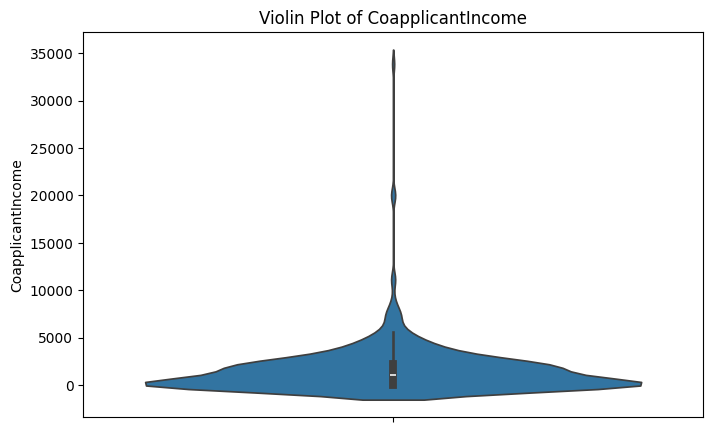

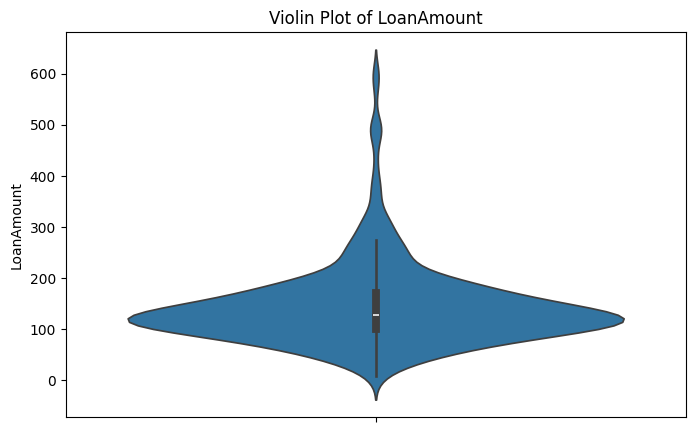

In [23]:
# Visualize outliers
display_outliers_violin(loan_data_df_cleaned, selected_columns=["ApplicantIncome", "CoapplicantIncome", "LoanAmount"])

## Columns Selection for Model Training

In [24]:
def filter_columns(dataframe, selected_columns):
    """
    Filters the dataframe to keep only the selected columns.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe to filter.
    - selected_columns (list): List of column names to keep in the dataframe.

    Returns:
    - pd.DataFrame: A dataframe containing only the selected columns.
    """
    missing_columns = [col for col in selected_columns if col not in dataframe.columns]
    if missing_columns:
        raise ValueError(f"The following columns are not in the dataframe: {missing_columns}")

    return dataframe[selected_columns]

# Specify the columns to keep (all but 'Loan_ID' for now)
selected_columns = ["Gender",
                    "Married",
                    "Dependents",
                    "Education",
                    "Self_Employed",
                    "ApplicantIncome",
                    "CoapplicantIncome",
                    "LoanAmount",
                    "Loan_Amount_Term",
                    "Credit_History",
                    "Property_Area",
                    "Loan_Status"]

# Filter the dataframe
filtered_df = filter_columns(loan_data_df_cleaned, selected_columns)

## Encoding

### Encode using various methods

In [25]:
def encode_categorical_columns(dataframe):
    """
    Encodes categorical columns based on predefined rules.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe containing the categorical columns.

    Returns:
    - pd.DataFrame: The dataframe with encoded categorical columns.
    """
    # Ensure we are working on a copy to avoid modifying the original dataframe
    dataframe = dataframe.copy()

    # Encode 'Gender' (0: Female, 1: Male)
    dataframe.loc[:, 'Gender'] = dataframe['Gender'].map({'Female': 0, 'Male': 1})

    # Encode 'Married' (0: No, 1: Yes)
    dataframe.loc[:, 'Married'] = dataframe['Married'].map({'No': 0, 'Yes': 1})

    # Encode 'Dependents' (ordinal: 0, 1, 2, 3+)
    dependents_mapping = {'0': 0, '1': 1, '2': 2, '3+': 3}
    dataframe.loc[:, 'Dependents'] = dataframe['Dependents'].map(dependents_mapping)

    # Encode 'Education' (0: Not Graduate, 1: Graduate)
    dataframe.loc[:, 'Education'] = dataframe['Education'].map({'Not Graduate': 0, 'Graduate': 1})

    # Encode 'Self_Employed' (0: No, 1: Yes)
    dataframe.loc[:, 'Self_Employed'] = dataframe['Self_Employed'].map({'No': 0, 'Yes': 1})

    # Encode 'Loan_Status' (0: N, 1: Y)
    dataframe.loc[:, 'Loan_Status'] = dataframe['Loan_Status'].map({'N': 0, 'Y': 1})

    # One-Hot Encode 'Property_Area'
    dataframe = pd.get_dummies(dataframe, columns=['Property_Area'], drop_first=False)

    return dataframe

# Encode categorical columns
encoded_df = encode_categorical_columns(filtered_df)

### Change column Types

In [26]:
def change_column_types(dataframe):
    """
    Changes the data types of specific columns in the dataframe.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe whose columns need type changes.

    Returns:
    - pd.DataFrame: The dataframe with updated column types.
    """
    # Define the desired data types for each column
    column_types = {
        "Gender": "int64",
        "Married": "int64",
        "Dependents": "float64",
        "Education": "int64",
        "Self_Employed": "int64",
        "Credit_History": "int64",
        "Loan_Status": "int64",
        "ApplicantIncome": "float64",
    }

    # Change column types
    for column, dtype in column_types.items():
        if column in dataframe.columns:
            dataframe[column] = dataframe[column].astype(dtype)
        else:
            print(f"Warning: Column '{column}' not found in the dataframe.")
    
    return dataframe

# Convert columns to the desired types
encoded_df = change_column_types(encoded_df)

encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, 1 to 613
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   480 non-null    int64  
 1   Married                  480 non-null    int64  
 2   Dependents               480 non-null    float64
 3   Education                480 non-null    int64  
 4   Self_Employed            480 non-null    int64  
 5   ApplicantIncome          480 non-null    float64
 6   CoapplicantIncome        480 non-null    float64
 7   LoanAmount               480 non-null    float64
 8   Loan_Amount_Term         480 non-null    float64
 9   Credit_History           480 non-null    int64  
 10  Loan_Status              480 non-null    int64  
 11  Property_Area_Rural      480 non-null    bool   
 12  Property_Area_Semiurban  480 non-null    bool   
 13  Property_Area_Urban      480 non-null    bool   
dtypes: bool(3), float64(5), int64(6

## Train/Test Split

### Split

In [27]:
def split_dataset(dataframe, split_percentage=0.8):
    """
    Splits a dataframe into training and testing datasets.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe to split.
    - split_percentage (float): The proportion of the dataset to include in the training set.

    Returns:
    - pd.DataFrame: Training dataset.
    - pd.DataFrame: Testing dataset.
    """
    if not (0 < split_percentage < 1):
        raise ValueError("split_percentage must be a float between 0 and 1.")

    train_df, test_df = train_test_split(dataframe, test_size=1-split_percentage, random_state=42)
    return train_df, test_df

train_df, test_df = split_dataset(encoded_df, split_percentage=0.8)

### Handle Target Variable Distribution

In [28]:
def balance_target_distribution(dataframe, target_variable):
    """
    Balances the distribution of the target variable by randomly removing rows from overrepresented classes.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe to balance.
    - target_variable (str): The name of the target column to balance.

    Returns:
    - pd.DataFrame: A dataframe with balanced target variable distribution.
    """
    # Count the number of rows in each class
    target_counts = dataframe[target_variable].value_counts()

    # Find the minimum count among all classes
    min_count = target_counts.min()

    # Balance each class
    balanced_df = pd.concat(
        [dataframe[dataframe[target_variable] == value].sample(min_count, random_state=42)
         for value in target_counts.index]
    )

    # Shuffle the balanced dataframe
    return balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Balance the target variable
train_df = balance_target_distribution(train_df, target_variable="Loan_Status")

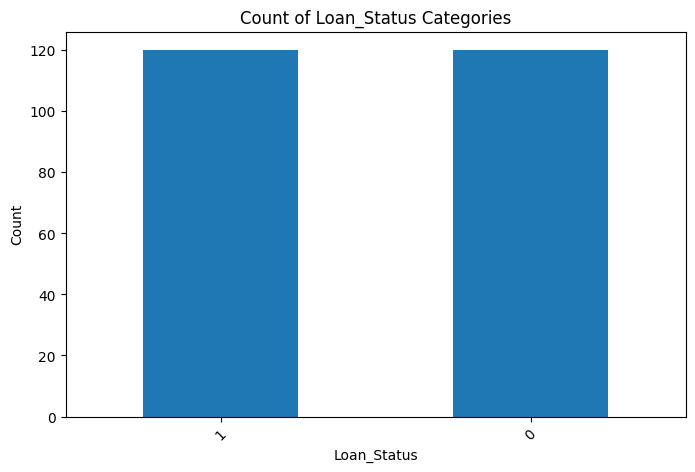

In [29]:
display_categorical_distribution(train_df, ["Loan_Status"])

### Split X/y

In [30]:
def create_train_test_sets(train_df, test_df, target_variable):
    """
    Splits the training and testing dataframes into features (X) and target (y) sets.

    Parameters:
    - train_df (pd.DataFrame): The training dataframe.
    - test_df (pd.DataFrame): The testing dataframe.
    - target_variable (str): The target variable column name.

    Returns:
    - X_train (pd.DataFrame): Features for training.
    - X_test (pd.DataFrame): Features for testing.
    - y_train (pd.Series): Target for training.
    - y_test (pd.Series): Target for testing.
    """
    X_train = train_df.drop(columns=[target_variable])
    y_train = train_df[target_variable]
    X_test = test_df.drop(columns=[target_variable])
    y_test = test_df[target_variable]
    
    return X_train, X_test, y_train, y_test

target_variable = "Loan_Status"
X_train, X_test, y_train, y_test = create_train_test_sets(train_df, test_df, target_variable)

## Standardization / Normalisation

Since I'm going to try a few different models, I'm choosing to just standardize the values instead of normalizing them. (for compatibility with all models)
I might change that in the future based on which model I end up using.

In [31]:
def standardize_columns(X_train, X_test, columns_to_standardize):
    """
    Standardizes specified columns in X_train and X_test.

    Parameters:
    - X_train (pd.DataFrame): Training data.
    - X_test (pd.DataFrame): Testing data.
    - columns_to_standardize (list): List of columns to standardize.

    Returns:
    - X_train (pd.DataFrame): Training data with standardized columns.
    - X_test (pd.DataFrame): Testing data with standardized columns.
    """
    # Create a scaler instance
    scaler = StandardScaler()

    # Fit scaler on the training set and transform both train and test sets
    X_train[columns_to_standardize] = scaler.fit_transform(X_train[columns_to_standardize])
    X_test[columns_to_standardize] = scaler.transform(X_test[columns_to_standardize])

    return X_train, X_test

# Specify numeric columns to standardize
columns_to_standardize = ["Dependents", "ApplicantIncome", 'CoapplicantIncome', "LoanAmount", 'Loan_Amount_Term']

# Standardize specified columns in X_train and X_test
X_train, X_test = standardize_columns(X_train, X_test, columns_to_standardize)

In [32]:
X_train.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,240.000000,240.000000,2.400000e+02,240.000000,240.000000,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,240.000000
mean,0.779167,0.595833,8.141636e-17,0.795833,0.170833,-4.810966e-17,2.960595e-17,-1.406282e-16,3.774758e-16,0.779167
std,0.415675,0.491756,1.002090e+00,0.403934,0.377150,1.002090e+00,1.002090e+00,1.002090e+00,1.002090e+00,0.415675
min,0.000000,0.000000,-7.502756e-01,0.000000,0.000000,-8.007029e-01,-5.200796e-01,-1.604712e+00,-4.256189e+00,0.000000
25%,1.000000,0.000000,-7.502756e-01,1.000000,0.000000,-4.047990e-01,-5.200796e-01,-5.569233e-01,3.002466e-01,1.000000
50%,1.000000,1.000000,-7.502756e-01,1.000000,0.000000,-2.716661e-01,-3.478700e-01,-1.920945e-01,3.002466e-01,1.000000
75%,1.000000,1.000000,2.445650e-01,1.000000,0.000000,5.194730e-02,2.048220e-01,3.099099e-01,3.002466e-01,1.000000
max,1.000000,1.000000,2.234246e+00,1.000000,1.000000,1.073297e+01,1.067504e+01,5.294930e+00,1.987815e+00,1.000000


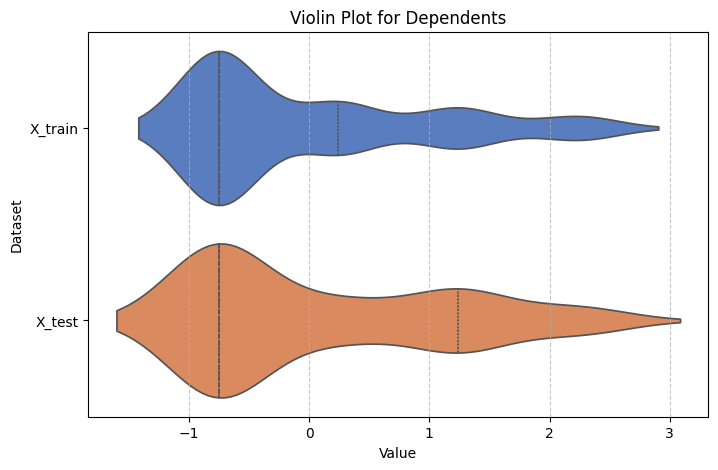

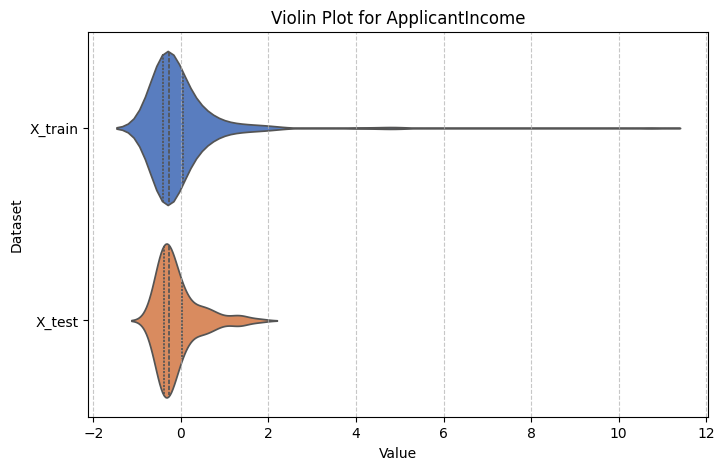

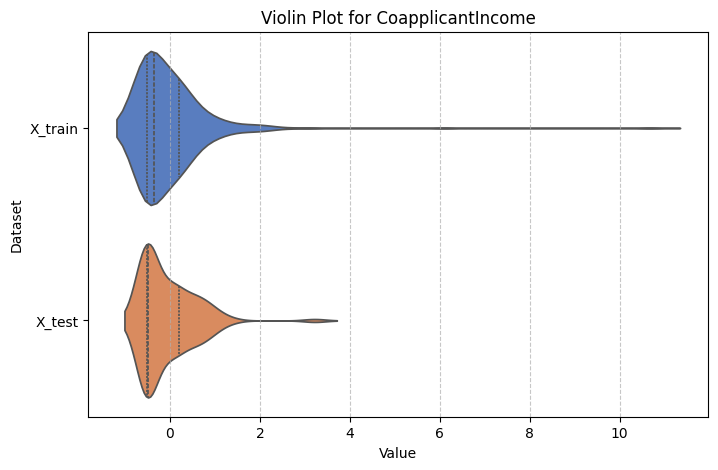

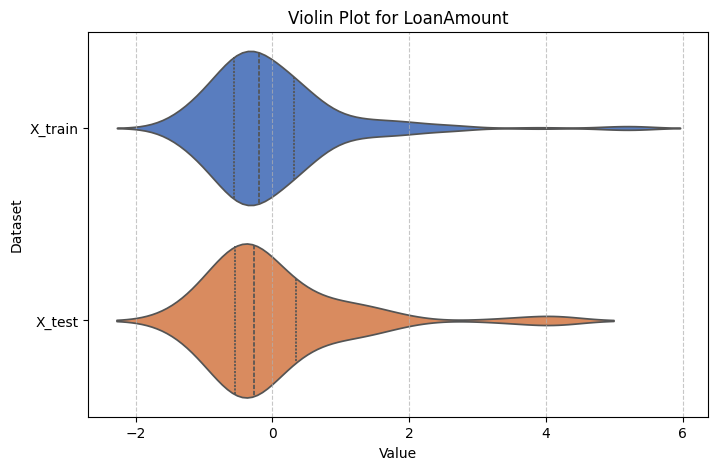

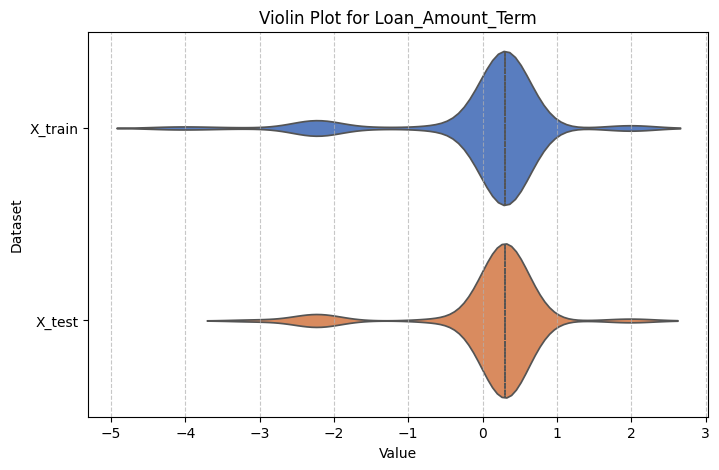

In [33]:
def visualize_violin_plots(X_train, X_test, columns_to_visualize):
    """
    Visualizes horizontal violin plots for the specified columns in X_train and X_test.

    Parameters:
    - X_train (pd.DataFrame): Training data.
    - X_test (pd.DataFrame): Testing data.
    - columns_to_visualize (list): List of columns to visualize.

    Returns:
    - None: Displays violin plots for each specified column.
    """
    for column in columns_to_visualize:
        plt.figure(figsize=(8, 5))
        
        # Combine train and test data for a shared violin plot
        combined_data = (
            pd.concat([
                X_train[column].to_frame().assign(Set="X_train"),
                X_test[column].to_frame().assign(Set="X_test")
            ])
            .rename(columns={column: "Value"})
        )

        # Plot horizontal violin plot with updated density_norm parameter
        sns.violinplot(
            x="Value", y="Set", data=combined_data, density_norm="width", inner="quartile", palette="muted", hue="Set", legend=False
        )
        
        plt.title(f"Violin Plot for {column}")
        plt.xlabel("Value")
        plt.ylabel("Dataset")
        plt.grid(axis="x", linestyle="--", alpha=0.7)
        plt.show()

columns_to_standardize = columns_to_standardize

# Visualize violin plots for specified columns
visualize_violin_plots(X_train, X_test, columns_to_visualize=columns_to_standardize)

## Model choice

### List of Models

In [34]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# List of models to test 
models = [
    RandomForestClassifier(), 
    LogisticRegression(), 
    SVC(),
    KNeighborsClassifier(), 
    GradientBoostingClassifier(), 
    HistGradientBoostingClassifier() 
]

### GridSearch


Running GridSearchCV for RandomForestClassifier...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\Utilisateur\Documents\GitHub Repos\Simplon\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200, 'n_jobs': -1, 'verbose': 0}
Best CV Accuracy: 0.6958
Best CV F1-Score: 0.7266
Best CV Precision: 0.6615
Test Set Accuracy: 0.7604
Test Set F1-Score: 0.8345
Precision: 0.8169



<Figure size 600x600 with 0 Axes>

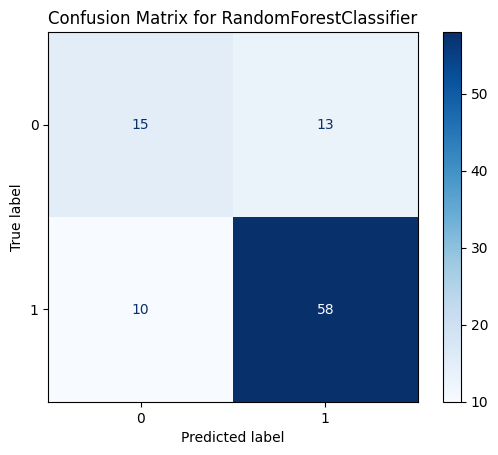


Running GridSearchCV for LogisticRegression...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'C': 0.1, 'l1_ratio': 0.5, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
Best CV Accuracy: 0.7208
Best CV F1-Score: 0.7810
Best CV Precision: 0.6496
Test Set Accuracy: 0.8229
Test Set F1-Score: 0.8889
Precision: 0.8000



<Figure size 600x600 with 0 Axes>

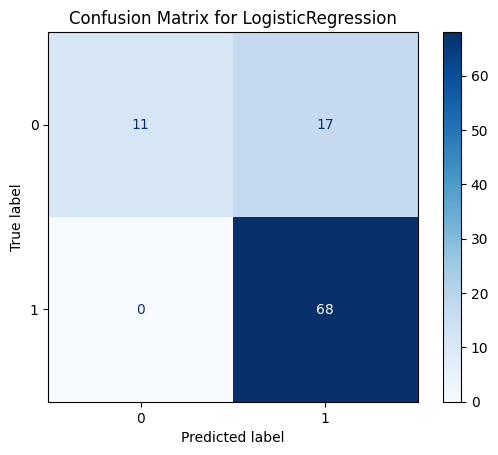


Running GridSearchCV for SVC...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'C': 10, 'coef0': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'sigmoid', 'verbose': False}
Best CV Accuracy: 0.7208
Best CV F1-Score: 0.7842
Best CV Precision: 0.6475
Test Set Accuracy: 0.8229
Test Set F1-Score: 0.8889
Precision: 0.8000



<Figure size 600x600 with 0 Axes>

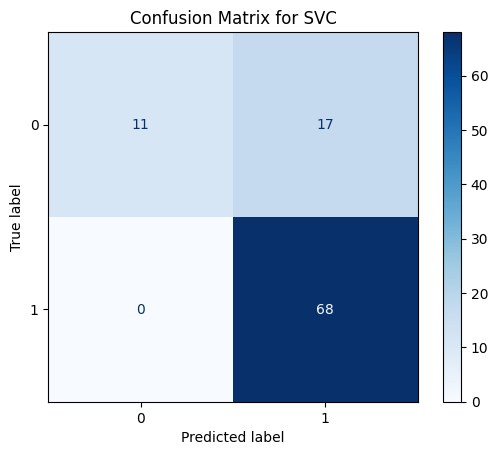


Running GridSearchCV for KNeighborsClassifier...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best CV Accuracy: 0.6042
Best CV F1-Score: 0.6410
Best CV Precision: 0.5874
Test Set Accuracy: 0.6875
Test Set F1-Score: 0.7727
Precision: 0.7969



c:\Users\Utilisateur\Documents\GitHub Repos\Simplon\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


<Figure size 600x600 with 0 Axes>

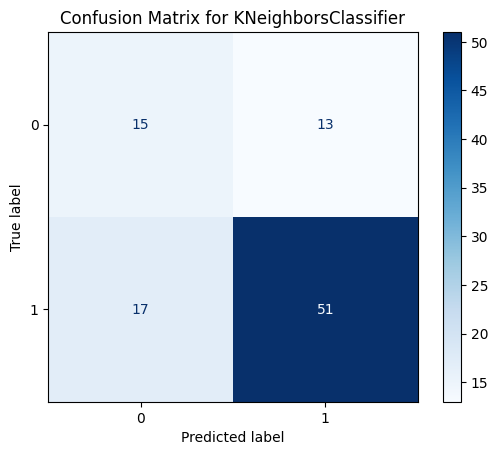


Running GridSearchCV for GradientBoostingClassifier...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}
Best CV Accuracy: 0.7208
Best CV F1-Score: 0.7671
Best CV Precision: 0.6600
Test Set Accuracy: 0.8125
Test Set F1-Score: 0.8816
Precision: 0.7976



<Figure size 600x600 with 0 Axes>

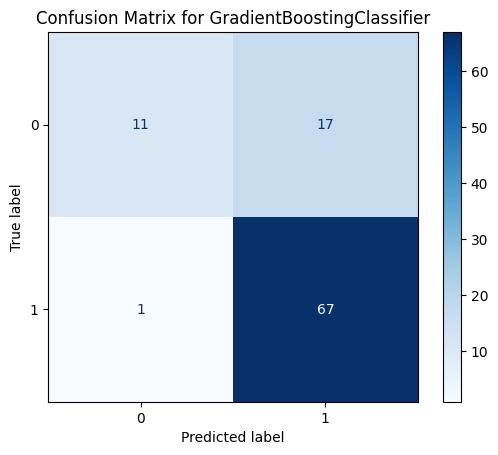


Running GridSearchCV for HistGradientBoostingClassifier...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'l2_regularization': 0.0, 'learning_rate': 0.01, 'max_depth': None, 'max_iter': 300, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'verbose': 0}
Best CV Accuracy: 0.7042
Best CV F1-Score: 0.7482
Best CV Precision: 0.6551
Test Set Accuracy: 0.7188
Test Set F1-Score: 0.8058
Precision: 0.7887



<Figure size 600x600 with 0 Axes>

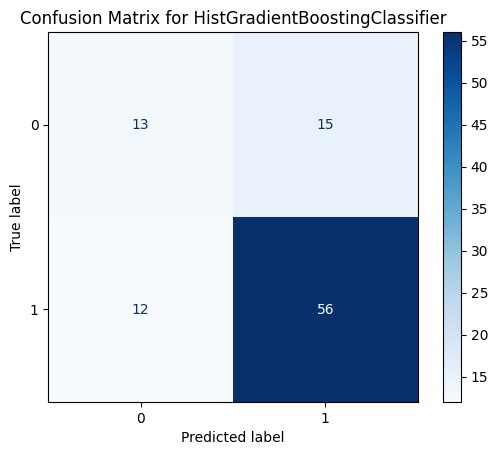


Best Model: RandomForestClassifier
Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200, 'n_jobs': -1, 'verbose': 0}
Test Accuracy: 0.7604
Test F1-Score: 0.8345
Precision: 0.8169


In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, precision_score

# Ignore RuntimeWarnings
import warnings
from sklearn.exceptions import ConvergenceWarning
#warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plots the confusion matrix for the given true and predicted values.

    Parameters:
    - y_true (array-like): True labels.
    - y_pred (array-like): Predicted labels.
    - model_name (str): Name of the model to display in the title.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

def run_gridsearch_on_models(models, param_grids, X_train, X_test, y_train, y_test, scoring='accuracy'):
    """
    Performs GridSearchCV for multiple models, finds the best parameters, and evaluates each model.

    Parameters:
    - models (list): List of models to test.
    - param_grids (list): List of parameter grids corresponding to each model.
    - X_train (pd.DataFrame): Training data features.
    - X_test (pd.DataFrame): Testing data features.
    - y_train (pd.Series): Training data labels.
    - y_test (pd.Series): Testing data labels.
    - scoring (str): Metric to evaluate performance (default: 'accuracy').

    Returns:
    - dict: A dictionary with model names as keys and their best scores, parameters, and test scores.
    """
    results = {}
    
    for model, param_grid in zip(models, param_grids):
        model_name = model.__class__.__name__
        print(f"\n\033[93mRunning GridSearchCV for\033[0m \033[92m{model_name}\033[0m...")
        
        # Use accuracy, F1-score, and precision as scoring metrics
        scoring_metrics = {
            'accuracy': 'accuracy',
            'f1': make_scorer(f1_score, average='binary'),
            'precision': make_scorer(precision_score, average='binary', zero_division=0)  # Handle undefined precision
        }

        # Set up GridSearchCV
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring=scoring_metrics,
            refit='precision',  # Use precision for selecting the best model
            cv=5,
            verbose=1
        )
        
        # Fit GridSearchCV
        grid_search.fit(X_train, y_train)
        
        # Get the best parameters and cross-validation scores
        best_params = grid_search.best_params_
        best_cv_accuracy = grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]
        best_cv_f1 = grid_search.cv_results_['mean_test_f1'][grid_search.best_index_]
        best_cv_precision = grid_search.cv_results_['mean_test_precision'][grid_search.best_index_]
        
        # Evaluate on the test set
        best_model = grid_search.best_estimator_
        y_test_pred = best_model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred)

        # Store results
        results[model_name] = {
            "Best Parameters": best_params,
            "Best CV Accuracy": best_cv_accuracy,
            "Best CV F1-Score": best_cv_f1,
            "Best CV Precision": best_cv_precision,
            "Test Set Accuracy": test_accuracy,
            "Test Set F1-Score": test_f1,
            "Test Set Precision": test_precision
        }
        
        print(f"\033[94mBest Parameters:\033[0m {best_params}")
        print(f"\033[94mBest CV Accuracy:\033[0m {best_cv_accuracy:.4f}")
        print(f"\033[94mBest CV F1-Score:\033[0m {best_cv_f1:.4f}")
        print(f"\033[94mBest CV Precision:\033[0m {best_cv_precision:.4f}")
        print(f"\033[94mTest Set Accuracy:\033[0m {test_accuracy:.4f}")
        print(f"\033[94mTest Set F1-Score:\033[0m {test_f1:.4f}")
        print(f"\033[92mPrecision:\033[0m {test_precision:.4f}\n")

        # Display confusion matrix
        plot_confusion_matrix(y_test, y_test_pred, model_name)
    
    # Find the best model based on test set Precision score
    best_model_name = max(results, key=lambda model: results[model]["Test Set Precision"])
    print(f"\n\033[94mBest Model:\033[0m \033[92m{best_model_name}\033[0m")
    print(f"\033[94mParameters:\033[0m {results[best_model_name]['Best Parameters']}")
    print(f"\033[94mTest Accuracy:\033[0m {results[best_model_name]['Test Set Accuracy']:.4f}")
    print(f"\033[94mTest F1-Score:\033[0m {results[best_model_name]['Test Set F1-Score']:.4f}")
    print(f"\033[92mPrecision:\033[0m {results[best_model_name]['Test Set Precision']:.4f}")
    
    return results

param_grids = [
    # RandomForestClassifier
    {
        #"n_estimators": [50, 100, 200],
        "n_estimators": [200],
        #"max_depth": [None, 10, 20],
        "max_depth": [None],
        #"min_samples_split": [2, 5],
        "min_samples_split": [5],
        #"min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf
        "min_samples_leaf": [4],
        #"max_features": ["sqrt", "log2", None],  # Number of features considered at each split
        "max_features": ["log2"],
        "bootstrap": [True, False],  # Whether to use bootstrapping
        "n_jobs": [-1],
        "verbose": [0]
    },
    
    # LogisticRegression
    {
        #"penalty": ["l1", "l2", "elasticnet", "none"],  # Add L1 (Lasso) and ElasticNet for sparsity
        "penalty": ["elasticnet"],
        "C": [0.01, 0.1, 1, 10],
        #"solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # SAGA supports L1 and ElasticNet
        "solver": ["saga"],
        "l1_ratio": [0.1, 0.5, 0.9],  # ElasticNet mixing ratio (only for saga solver)
        "max_iter": [100, 200, 500, 1000]  # Increase max iterations for convergence
    },
    
    # SVC
    {
        "C": [0.1, 1, 10],
        #"kernel": ["linear", "rbf", "poly", "sigmoid"],  # Include polynomial and sigmoid kernels
        "kernel": ["sigmoid"],
        "gamma": ["scale", "auto", 0.01, 0.1],  # Add specific gamma values
        "degree": [2, 3, 4],  # Degree of the polynomial kernel (only for 'poly')
        "coef0": [0.0, 0.1, 0.5],  # Independent term in kernel function (useful for 'poly' and 'sigmoid')
        "verbose": [False]
    },
    
    # KNeighborsClassifier
    {
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski", "chebyshev"],  # Add more distance metrics
        "p": [1, 2, 3],  # Power parameter for Minkowski metric
        "n_jobs": [-1]
    },
    
    # GradientBoostingClassifier
    {
        #"n_estimators": [50, 100, 200],
        "n_estimators": [100],
        #"learning_rate": [0.01, 0.1, 0.2],
        "learning_rate": [0.01],
        #"max_depth": [3, 5, 7],
        "max_depth": [3],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2, 4],
        #"subsample": [0.7, 0.8, 1.0],  # Fraction of samples used for training each tree
        "subsample": [1.0],
        #"max_features": ["sqrt", "log2", None]  # Number of features considered at each split
        "max_features": ["log2"]
    },
    
    # HistGradientBoostingClassifier
    {
        #"learning_rate": [0.01, 0.1, 0.2],
        "learning_rate": [0.01],
        #"max_iter": [100, 200, 300],
        "max_iter": [300],
        #"max_depth": [None, 10, 20],
        "max_depth": [None],
        #"l2_regularization": [0.0, 0.1, 1.0],  # L2 regularization strength
        "l2_regularization": [0.0],
        "min_samples_leaf": [10, 20, 30],  # Minimum samples per leaf
        "max_leaf_nodes": [31, 50, 100],  # Maximum number of leaves in the tree
        "verbose": [0]
    }
]

grid_search_results = run_gridsearch_on_models(models, param_grids, X_train, X_test, y_train, y_test)

# Re-enable warnings
#warnings.resetwarnings()

### RandomizedSearch

## Model training

## Model Evaluation